# Machine Learning Foundation

## Course 6, Part f: SARIMA and Prophet DEMO


## Learning Outcomes
You should walk away from this notebook with:
1. A practical understanding of **Autoregressive Integrated Moving Average (ARIMA)** models.
2. Insight into checking fit of model.
3. Learn to create forecasts with **ARIMA models** in Python.
4. A practical understanding of **fbprophet**.
5. How to check fit of **fbprophet model**.
6. Means of adjusting and improving fbprophet model parameters.


# Overview: Time Series Modeling Approaches

In previous lessons, we explored Python implementations of fundamental time series concepts including stationarity, smoothing, trend, seasonality, and autocorrelation, and built two kinds of models: 

  * **MA models**: Specify that the current value of the series depends linearly on the series' mean and a set of prior (observed) white noise error terms.
  * **AR models**: Specify that the current value of the  series depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term).

In the current lesson we will review these concepts as well as combine these two model types into three more complicated time series models: **ARMA, ARIMA, and SARIMA.** We will then explore a different type of Time Series modeling using __[Facebook Prophet](https://facebook.github.io/prophet/https://facebook.github.io/prophet/)__. 

__Installation notes:__

[Prophet holiday issues](https://stackoverflow.com/questions/60145006/cannot-import-name-easter-from-holidays)

To install __[pdarima](https://pypi.org/project/pmdarima/)__ on Anaconda, use:

[conda install -c saravji pdarima](https://anaconda.org/saravji/pmdarima)

In [1]:
# Setup
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from prophet import Prophet
import pmdarima as pm

import warnings
warnings.simplefilter(action='ignore')

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Section 1: Time Series Review

We've covered lots of material in the previous four lessons. Now is a good time to step back and rehash what we've covered. This will help to both solidify concepts and ensure you're ready to tackle ARMA, ARIMA, and SARIMA models.

### Section 1.1: Examples of time series data and modeling:
- Hedge fund prediction of stock and index movements
- Long and short-term weather forecasting
- Business budgeting and trend analysis
- Health vitals monitoring
- Traffic flows and logistic optimization modeling
- Can you think of others?

### Section 1.2: Decomposition
Time series data can often be decomposed into **trend**, **seasonal**, and **random fluctuation components**.

Decomposition

- **Trends**
    - Up
    - Down
    - Flat
    - Larger trends can be made up of smaller trends
    - There is no defined timeframe for what constitutes a trend as it depends on your goals
- **Seasonal Effects**
    - Weekend retail sales spikes
    - Holiday shopping
    - Energy requirement changes with annual weather patterns
    - Note: Twitter spikes when news happens are not seasonal because they aren't regular and predictable
- **Random Fluctuations**
    - The human element
    - Aggregations of small influencers
    - Observation errors
    - The smaller this is in relation to Trend and Seasonal, the better we can predict the future

### Section 1.3: Additive vs Multiplicative
Time series models fall into [two camps](http://www.abs.gov.au/websitedbs/D3310114.nsf/home/Time+Series+Analysis:+The+Basics#HOW%20DO%20I%20KNOW%20WHICH%20DECOMPOSITION):
- **Additive**
    - **Data = Trend + Seasonal + Random**
    - What we will be using for our modeling
- **Multiplicative**
    - **Data = Trend x Seasonal x Random**
    - As easy to fit as Additive if we take the log
        - log(Data) = log(Trend x Seasonal x Random)
        
***
- We should **use multiplicative models when the percentage change of our data is more important than the absolute value change** (e.g. stocks, commodities); as the trend rises and our values grow, we see amplitude growth in seasonal and random fluctuations. 
- **If our seasonality and fluctuations are stable, we likely have an additive model.**

### Section 1.4: Time Series Modeling Process
Time series model selection is driven by the Trend and Seasonal components of our raw data. The general approach for analysis looks like this:

1. Plot the data and determine Trends and Seasonality
    1. Difference or take the log of the data (multiple times if needed) to remove trends for [certain model applications](https://en.wikipedia.org/wiki/Stationary_process)
    1. **Stationairity is needed for ARMA models**
1. Determine if we have additive or multiplicative data patterns
1. Select the appropriate algorithm based on the chart below
1. Determine if model selection is correct with these tools
    - Ljung-Box Test
    - Residual Errors (Normal Distribution with zero mean and constant variance-homoskedastic, i.i.d)
    - Autocorrelation Function (ACF)
    - Partial Autocorrelation Function (PACF)

Algorithm | Trend | Seasonal | Correlations
---|---|---|---
ARIMA | X |X|X
SMA Smoothing |X||
Simple Exponential Smoothing |X||
Seasonal Adjustment |X|X|
Holt's Exponential Smoothing |X||
Holt-Winters |X|X|

### Section 1.5: How to Achieve and Test for Stationarity
- The mean of the series is not a function of time.
- The variance of the series is not a function of time (homoscedasticity).
- The covariance at different lags is not a function of time.

[From A Complete Tutorial on Time Series Modeling in R](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/)

- [Info on stationarity](http://www.investopedia.com/articles/trading/07/stationary.asp)
- Plotting Rolling Statistics
    - Plot the moving average/variance and see if it changes with time. 
    - This visual technique can be done on different windows, but isn't as rigorously defensible as the test below.
- Augmented Dickey-Fuller Test
    - Statistical tests for checking stationarity; the null hypothesis is that the TS is non-stationary. If our test statistic is below an `alpha` value, we _can_ reject the null hypothesis and say that the series is stationary.
    
    $$ Y_t = \rho * Y_{t-1} + \epsilon_t $$
    
    $$ Y_t - Y_{t-1} = (\rho - 1) Y_{t - 1} + \epsilon_t $$
    
### Section 1.6: Differencing Example

This will give us a reminder to how differencing is used to get a stationary series which will be essential to the final piece of the ARIMA model

In [3]:
# create a play dataframe from 1-10 (linear and squared) to test how differencing works
play = pd.DataFrame([[x for x in range(1,11)], [x**2 for x in range(1,11)]]).T
play.columns = ['original', 'squared']
play

,original,squared
0,1,1
1,2,4
2,3,9
3,4,16
4,5,25
5,6,36
6,7,49
7,8,64
8,9,81
9,10,100


In [4]:
# stationarize linear series (mean and variance don't change for sub-windows)
play.original.diff()

0    NaN
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: original, dtype: float64

Text(0.5, 1.0, 'second diff')

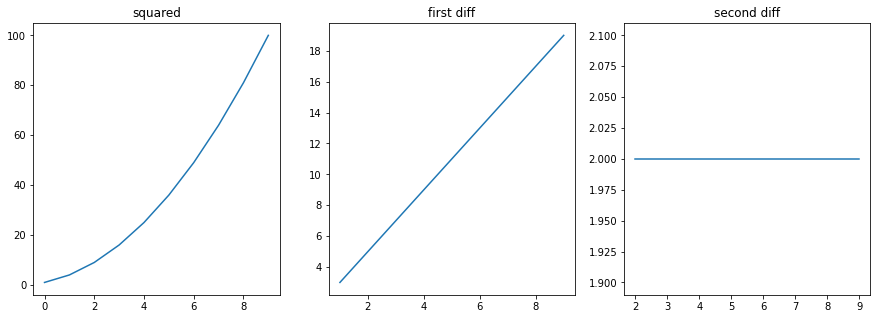

In [5]:
fig,axes = plt.subplots(1,3,figsize = (15,5))
axes[0].plot(play.squared)
axes[0].set_title('squared')
axes[1].plot(play.squared.diff())
axes[1].set_title('first diff')
axes[2].plot(play.squared.diff().diff())
axes[2].set_title('second diff')


**NOTE:** This is similar to taking a first-order derivative.

In [6]:
# stationarize squared series
play.squared.diff().diff()

0    NaN
1    NaN
2    2.0
3    2.0
4    2.0
5    2.0
6    2.0
7    2.0
8    2.0
9    2.0
Name: squared, dtype: float64

**NOTE:** Notice **we need to difference twice on an exponential trend**, and every time we do, we lose a bit of data

In [7]:
# stationarize squared with log
np.log(play.squared)

0    0.000000
1    1.386294
2    2.197225
3    2.772589
4    3.218876
5    3.583519
6    3.891820
7    4.158883
8    4.394449
9    4.605170
Name: squared, dtype: float64

**NOTE:** Works somewhat but certainly not as well.

Text(0.5, 1.0, 'log')

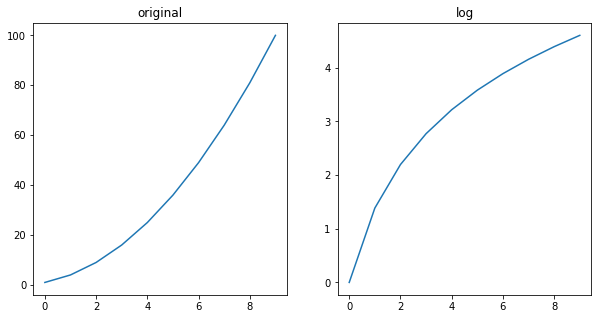

In [8]:
fig,axes = plt.subplots(1,2,figsize = (10,5))
axes[0].plot(play.squared)
axes[0].set_title('original')
axes[1].plot(np.log(play.squared))
axes[1].set_title('log')

## Data Prep and EDA

We'll be looking at [monthly average temperatures between 1907-1972](https://datamarket.com/data/set/22o4/mean-monthly-temperature-1907-1972#!ds=22o4&display=line)

In [9]:
# load data and convert to datetime
monthly_temp = pd.read_csv("mean-monthly-temperature-1907-19.csv",
                          skipfooter=2,
                          infer_datetime_format=True,
                          header=0, index_col=0,
                          engine="python",
                          names=['month', 'temp'])
monthly_temp.index = pd.to_datetime(monthly_temp.index)

In [10]:
monthly_temp.head()

,temp
month,
1907-01-01,33.3
1907-02-01,46.0
1907-03-01,43.0
1907-04-01,55.0
1907-05-01,51.8


In [11]:
monthly_temp.describe()

,temp
count,792.000000
mean,53.553662
std,15.815452
min,11.200000
25%,39.675000
50%,52.150000
75%,67.200000
max,82.400000


In [12]:
monthly_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 792 entries, 1907-01-01 to 1972-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    792 non-null    float64
dtypes: float64(1)
memory usage: 12.4 KB


### Resample to Annual and plot each

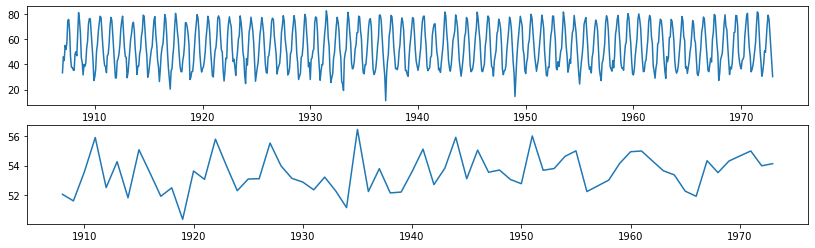

In [13]:
plt.rcParams['figure.figsize'] = [14,4]
annual_temp = monthly_temp.resample('A').mean()
fig, axes = plt.subplots(2, 1)
axes[0].plot(monthly_temp)
axes[1].plot(annual_temp)
plt.show()

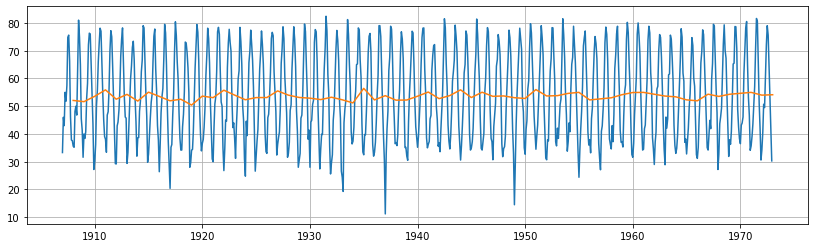

In [14]:
# plot both on same figure
plt.plot(monthly_temp)
plt.plot(annual_temp)
plt.grid(b=True)
plt.show()

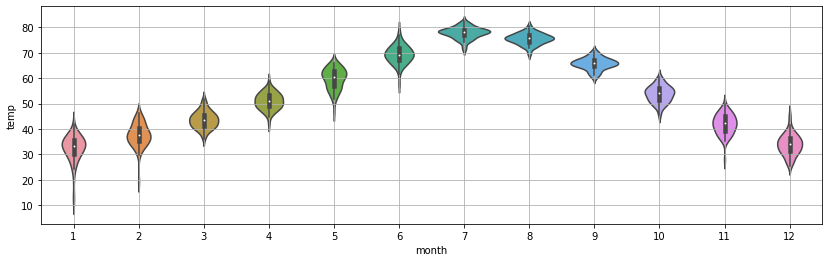

In [15]:
# violinplot of months to determine variance and range
sns.violinplot(x=monthly_temp.index.month, y=monthly_temp.temp)
plt.grid(b=True)

In [16]:
# split data into 12 chunks
chunks = np.split(monthly_temp.temp, indices_or_sections=12)

In [17]:
mean_vals = np.mean(chunks, axis=1)
var_vals = np.var(chunks, axis=1)
vals = {'mean_vals': mean_vals, 'var_vals': var_vals}
mean_var = pd.DataFrame(vals)
mean_var

,mean_vals,var_vals
0,52.674242,225.907973
1,53.654545,246.031570
2,52.837879,247.400838
3,54.078788,250.787429
4,52.439394,277.865721
5,53.457576,283.619412
6,53.718182,224.882397
7,54.422727,265.442059
8,53.457576,238.561230
9,54.425758,257.425852


In [18]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts

def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic', 'p-value', 'Lags Used', 'Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic         -6.481466e+00
p-value                 1.291867e-08
Lags Used               2.100000e+01
Observations Used       7.700000e+02
Critical Value (1%)    -3.438871e+00
Critical Value (5%)    -2.865301e+00
Critical Value (10%)   -2.568773e+00
dtype: float64


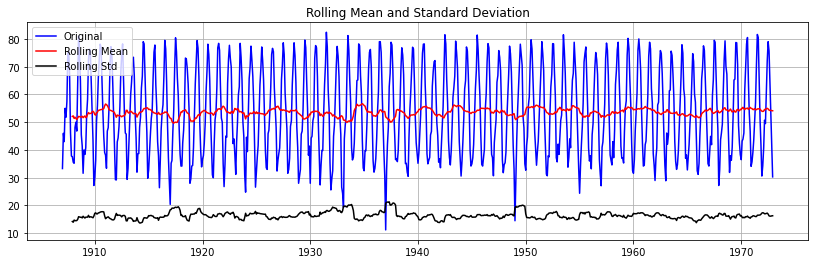

In [19]:
# run DFT on monthly
dftest(monthly_temp.temp)


Test Statistic         -7.878242e+00
p-value                 4.779473e-12
Lags Used               0.000000e+00
Observations Used       6.500000e+01
Critical Value (1%)    -3.535217e+00
Critical Value (5%)    -2.907154e+00
Critical Value (10%)   -2.591103e+00
dtype: float64


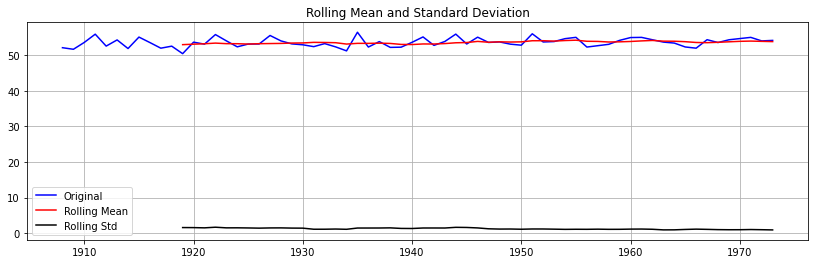

In [20]:
# run DFT on annual
dftest(annual_temp.temp)

#### p-value allows us to reject a unit root: data is stationary

Test Statistic          -0.449458
p-value                  0.901508
Lags Used               10.000000
Observations Used       55.000000
Critical Value (1%)     -3.555273
Critical Value (5%)     -2.915731
Critical Value (10%)    -2.595670
dtype: float64


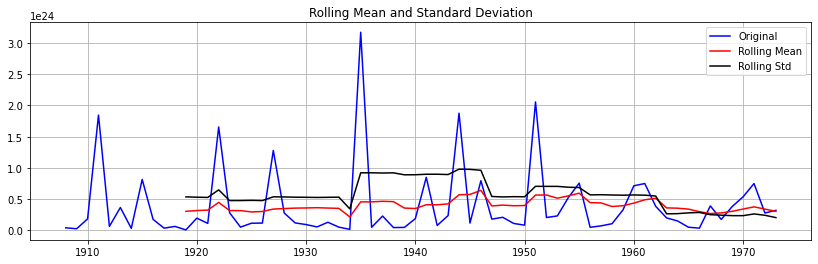

In [21]:
# here's an example of non-stationary with DFT results
dftest(np.exp(annual_temp.temp))

- Important to note that values have strong seasonality and adf test as well as rolling mean may not capture this.
- That is why it is always important to pay attention to run sequence plot

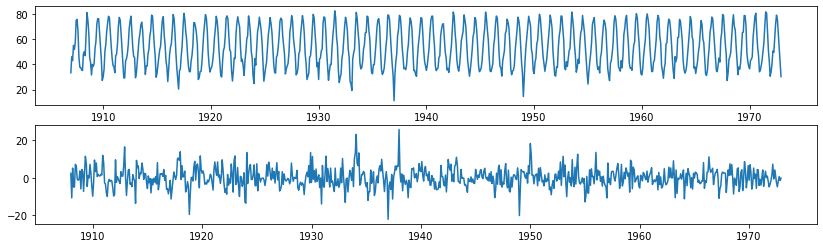

In [22]:
monthly_temp['lag_12'] = monthly_temp.shift(12)
monthly_temp['seasonal_diff'] = monthly_temp.temp - monthly_temp['lag_12']

fig, axes = plt.subplots(2, 1)
axes[0].plot(monthly_temp.temp, label="original")
axes[1].plot(monthly_temp.seasonal_diff, label="seasonal diff")
plt.show()

## Section 2: SARIMA with Statsmodels

- We went through **getting stationary data and differencing** as that is the last piece of the puzzle that we are missing for understanding ARIMA models. 
- **The I stands for "Integrated" which just refers to the amount of differcing done on the data.**

When we are determining our **ARIMA** model we will come across the following standard inputs:
- order(p,d,q):
    - **p is number of AR terms**
    - **d is number of times that we would difference our data**
    - **q is number of MA terms**
    
When we work with **SARIMA models 'S' refers to 'seasonal'** and we have the additional standard inputs:
- seasonal order(p,d,q):
    - **p is number of AR terms in regards to seasonal lag**
    - **d is number of times that we would difference our seasonal lag (as seen above)**
    - **q is number of MA terms in regards to seasonal lag**
    - **s is number of periods in a season**

Reminder of some good resources:
- [ARIMA in R](https://www.otexts.org/fpp/8/5)
- [Duke ARIMA Guide](https://people.duke.edu/~rnau/411arim2.htm)
- [Great explanation on MA in practice](http://stats.stackexchange.com/questions/164824/moving-average-ma-process-numerical-intuition)

Some rules to highlight from the Duke ARIMA Guide:
- If the series **has positive autocorrelations out to a high number of lags**, then it probably **needs a higher order of differencing.**
- If the **lag-1 autocorrelation is zero or negative**, or the **autocorrelations are all small and patternless**, then **the series does not need a higher order of  differencing.** 
    - **If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.**  BEWARE OF OVERDIFFERENCING!!
- **A model with no orders of differencing assumes that the original series is stationary (mean-reverting)**. 
    - **A model with one order of differencing** assumes that the original series has a **constant average trend** (e.g. a random walk or SES-type model, with or without growth). 
    - **A model with two orders of total differencing** assumes that the original series has a **time-varying trend** (e.g. a random trend or LES-type model)

### Create Helper Functions

In [23]:
# define helper plot function for visualization
def plots(data, lags=None):
    layout = (1, 3)
    raw = plt.subplot2grid(layout, (0, 0))
    acf = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

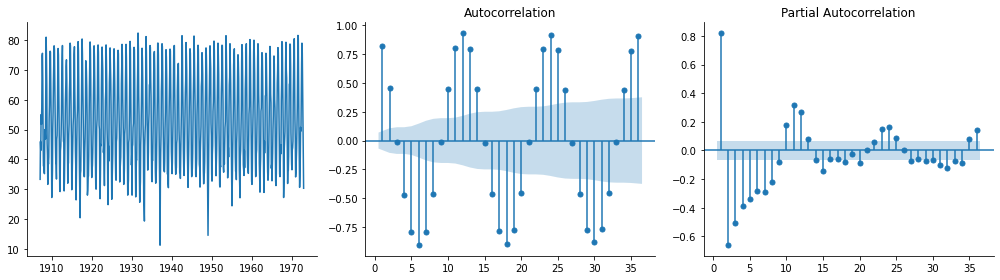

In [24]:
# helper plot for monthly temps
plots(monthly_temp.temp, lags=36);
# open Duke guide for visual
# we note a 12-period cycle (yearly) with suspension bridge design, so must use SARIMA

### [Box-Jenkins Method](https://en.wikipedia.org/wiki/Box–Jenkins_method)

ACF Shape|Indicated Model
---|---
Exponential, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model.
Alternating positive and negative, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to help identify the order.
One or more spikes, rest are essentially zero|Moving average model, order identified by where plot becomes zero.
Decay, starting after a few lags|Mixed autoregressive and moving average (ARMA) model.
All zero or close to zero|Data are essentially random.
High values at fixed intervals|Include seasonal autoregressive term.
No decay to zero|Series is not stationary.

In [25]:
# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(monthly_temp.temp,
                                order=(1,0,0),
                                seasonal_order=(0,1,1,12),
                                trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                  792
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -2128.873
Date:                              Wed, 29 Sep 2021   AIC                           4265.746
Time:                                      05:36:00   BIC                           4284.383
Sample:                                  01-01-1907   HQIC                          4272.914
                                       - 12-01-1972                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0127      0.007      1.698      0.090      -0.002       0.027
ar.L1          0.1791      0.035      5.105      0.000       0.110       0.248
ma.S.L12      -0.9995      1.139     -0.878      0.380      -3.232       1.233
sigma2        12.8927     14.566      0.885      0.376     -15.656      41.442
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               252.77
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.56
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

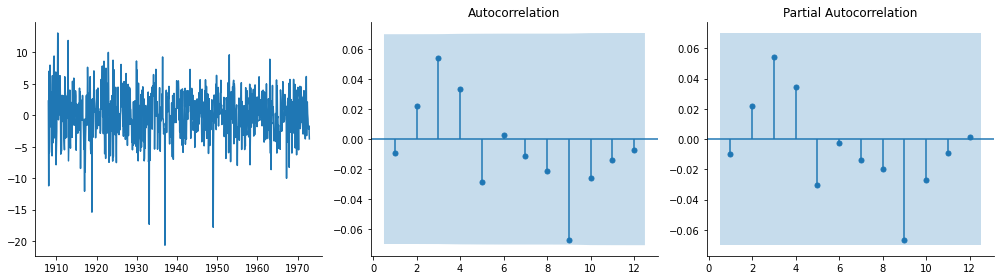

In [26]:
# plot resids
plots(sar.resid[sar.loglikelihood_burn:], lags=12);

**Thought process:**  

010010 is probably overdifferenced as we can see by negative ACF at lag 1

000010 is a big underdiff at seasonal lag, but with better AIC

Looks like 000010,12 and Trend='c' per rule

Looking back at seasonal we notice negative ACR spike at 12: we will thus add a SMA term and we see a big drop in AIC to 4289

looks like ACF looks good at seasonal lags, so we move back to ARIMA portion.

ACF shows we can use AR terms. AR=1,2 or 3 have similar AIC

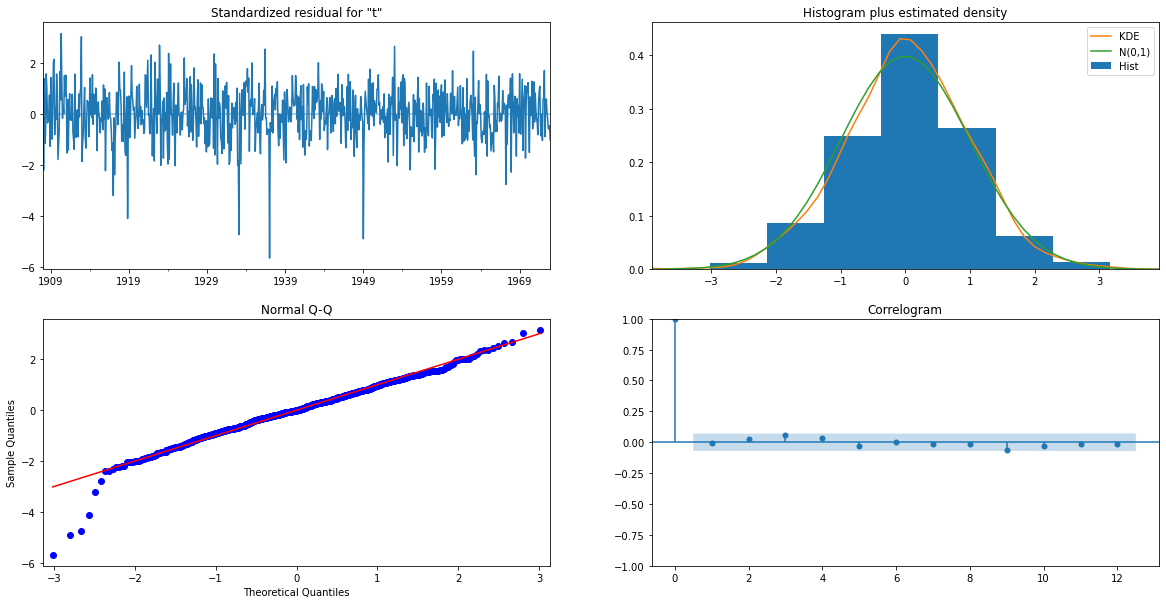

In [27]:
# plot residual diagnostics
sar.plot_diagnostics(lags=12,figsize = (20,10),);

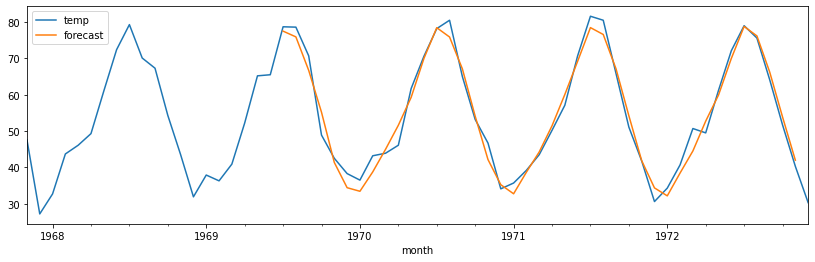

In [28]:
# plot predictions
pd.plotting.register_matplotlib_converters()
#use model.predict() start and end in relation to series
monthly_temp['forecast'] = sar.predict(start= 750, end= 790)
monthly_temp[730:][['temp', 'forecast']].plot();

In [29]:
#Introducing another model
sar2 = sm.tsa.statespace.SARIMAX(monthly_temp.temp, 
                                order=(3,0,0), 
                                seasonal_order=(0,1,1,12), 
                                trend='c').fit()

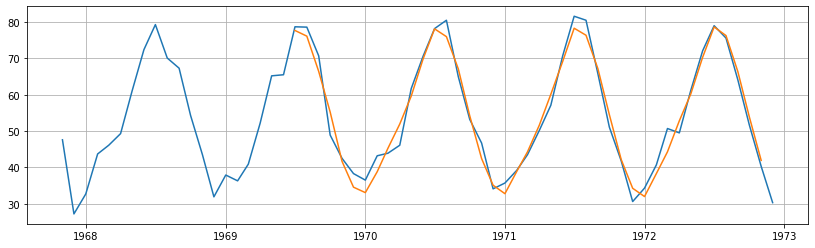

In [30]:
# plot predictions
monthly_temp['forecast'] = sar2.predict(start = 750, end= 790, dynamic=False)  
plt.plot(monthly_temp[730:][['temp', 'forecast']])
plt.grid();

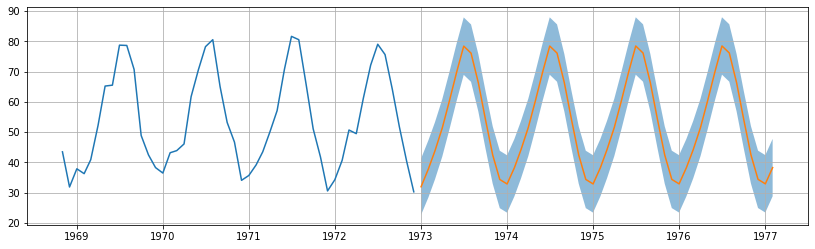

In [31]:
# can use get forecast to create a forecast object
future_fcst = sar2.get_forecast(50)
# That will have a method to pull in confidence interval 
confidence_int = future_fcst.conf_int(alpha = 0.01)
# Has an attribute to pull in predicted mean
fcst = future_fcst.predicted_mean
# Plot predictions and confidence intervals
plt.plot(monthly_temp.temp[-50:])
plt.plot(fcst)
plt.fill_between(confidence_int.index,confidence_int['lower temp'],confidence_int['upper temp'],alpha = 0.5)
plt.grid()

## Section 3: Statistical Tests


- [Normality (Jarque-Bera)](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality)
    - Null hypothesis is normally distributed residuals (good, plays well with RMSE and similar error metrics)

- [Serial correlation (Ljung-Box)](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation)
    - Null hypothesis is no serial correlation in residuals (independent of each other)

- [Heteroskedasticity](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity)
    - Tests for change in variance between residuals.
    - The null hypothesis is no heteroskedasticity. That means different things depending on which alternative is selected:
        - **Increasing:** Null hypothesis is that the variance is not increasing throughout the sample; that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.
        - **Decreasing:** Null hypothesis is that the variance is not decreasing throughout the sample; that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the later subsample.
        - **Two-sided (default):** Null hypothesis is that the variance is not changing throughout the sample. Both that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the later subsample and that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.

- [Durbin Watson](https://en.wikipedia.org/wiki/Durbin–Watson_statistic)
    - Tests autocorrelation of residuals: we want between 1-3, 2 is ideal (no serial correlation)

In [32]:
sar.test_normality?

In [33]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
lb_val, lb_p = sar.test_serial_correlation(method='ljungbox',)[0]
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]


# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(
    sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print(f"Normality:{norm_val:.3f}, p={norm_p:.3f}")
print(f"Ljung-Box:{lb_val:.3f}, p={lb_p:.3f}")
print(f"Heteroskedasticity: val={het_val:.3f}, p={het_p:.3f}")
print(f"Durbin-Watson: d={durbin_watson:.2f}")

Normality:252.769, p=0.000
Ljung-Box:15.499, p=0.905
Heteroskedasticity: val=0.708, p=0.006
Durbin-Watson: d=2.01


### Note on autofit methods
- R has an autoARIMA function (and other automagic methods) that gridsearches/optimizes our model hyperparameters for us. 
- Over time, more of these goodies are porting to Python (e.g. **pmdarima**).
- While there's nothing wrong with utilizing these resources, the _human makes the final determination!_ 
- Don't become over-reliant on these methods, especially early on when you are grasping the underlying mechanics and theory!

In [34]:
#from pyramid.arima import auto_arima
stepwise_model = pm.auto_arima(monthly_temp.temp, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.80 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=4796.839, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4546.179, Time=0.70 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=4794.867, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=4769.737, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=4451.142, Time=1.62 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.79 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.11 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=4477.926, Time=1.80 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=4452.084, Time=1.78 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=4450.271, Time=2.30 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=4545.537, Time=0.94 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=6.77 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=i

In [35]:
from dateutil.relativedelta import relativedelta
def future_preds_df(model,series,num_months):
    pred_first = series.index.max()+relativedelta(months=1)
    pred_last = series.index.max()+relativedelta(months=num_months)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'MS')
    vals = model.predict(n_periods = num_months)
    return pd.DataFrame(vals,index = date_range_index)

In [36]:
preds = future_preds_df(stepwise_model,monthly_temp.temp,100)

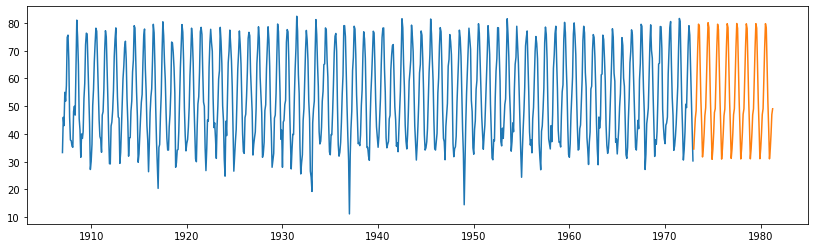

In [37]:
plt.plot(monthly_temp.temp)
plt.plot(preds)

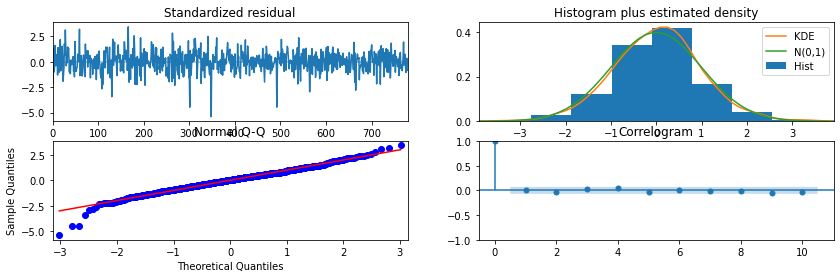

In [38]:
stepwise_model.plot_diagnostics();

In [39]:
print(f"auto-fit order: {stepwise_model.order}")
print(f"auto-fit seasonal order: {stepwise_model.seasonal_order}")

auto-fit order: (1, 0, 1)
auto-fit seasonal order: (2, 1, 0, 12)


When deciding on a model, often what truly matters is how well we would be able to produce out of sample predictions.
Here we create a function that looks at multiple out of sample predictions to see which model had lowest out of sample error

In [40]:
def cross_validate(series,horizon,start,step_size,order = (1,0,0),seasonal_order = (0,0,0,0),trend=None):
    '''
    Function to determine in and out of sample testing of arima model    
    
    arguments
    ---------
    series (seris): time series input
    horizon (int): how far in advance forecast is needed
    start (int): starting location in series
    step_size (int): how often to recalculate forecast
    order (tuple): (p,d,q) order of the model
    seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    
    Returns
    -------
    DataFrame: gives fcst and actuals with date of prediction
    '''
    fcst = []
    actual = []
    date = []
    for i in range(start,len(series)-horizon,step_size):
        model = sm.tsa.statespace.SARIMAX(series[:i+1], #only using data through to and including start 
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=trend).fit()
        fcst.append(model.forecast(steps = horizon)[-1]) #forecasting horizon steps into the future
        actual.append(series[i+horizon]) # comparing that to actual value at that point
        date.append(series.index[i+horizon]) # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)

In [41]:
warnings.filterwarnings("ignore")
series = monthly_temp.temp
horizon = 12
start = 700
step_size = 3
order = (1,0,0)
seasonal_order = (0,1,1,12)

cv1 = cross_validate(monthly_temp.temp,12,700,3,
                    order = order,
                    seasonal_order = seasonal_order)

In [42]:
#example to see underpinning of cv

model = sm.tsa.statespace.SARIMAX(series[:701], #only using data through start of 700
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=None).fit()

In [43]:
#end of input
series[:701].tail()

month
1965-01-01    32.8
1965-02-01    37.8
1965-03-01    42.0
1965-04-01    49.8
1965-05-01    54.5
Name: temp, dtype: float64

In [44]:
#value to predict horizon steps into the future
series[712:713]

month
1966-05-01    65.6
Name: temp, dtype: float64

In [45]:
# what model predicted for that date
model.forecast(12)[-1:]

1966-05-01    59.580987
Freq: MS, Name: predicted_mean, dtype: float64

In [46]:
cv1.head()

,fcst,actual
1966-05-01,59.580987,65.6
1966-08-01,75.351410,75.8
1966-11-01,41.607102,45.3
1967-02-01,37.584437,39.6
1967-05-01,59.753916,59.6


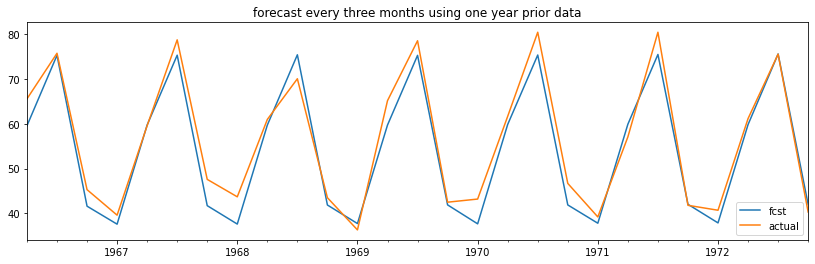

In [47]:
cv1.plot(title = 'forecast every three months using one year prior data')
plt.show()

In [48]:
#Defining an error metric to see out of sample accuracy
def mape(df_cv):
    return abs(df_cv.actual - df_cv.fcst).sum() / df_cv.actual.sum()

In [49]:
mape(cv1)

0.05214795806149404

In [50]:
warnings.filterwarnings("ignore")
series = monthly_temp.temp
horizon = 12
start = 700
step_size = 3
order = (1,1,0)
seasonal_order = (0,1,1,12)

cv2 = cross_validate(monthly_temp.temp,12,700,3,
                    order = order,
                    seasonal_order = seasonal_order)

In [51]:
mape(cv2)

0.06835852414033841

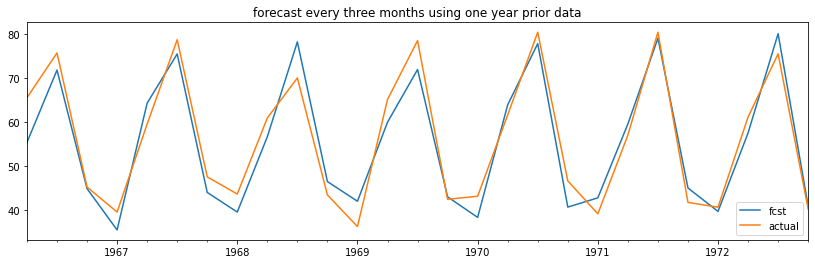

In [52]:
cv2.plot(title = 'forecast every three months using one year prior data')
plt.show()

In [53]:
len(monthly_temp.temp)

792

In [54]:
def grid_search_ARIMA(series,horizon,start,step_size,orders = [(1,0,0)],seasonal_orders = [(0,0,0,0)],trends=[None]):
    best_mape = np.inf
    best_order = None
    best_seasonal_order = None
    best_trend = None
    for order_ in orders:
        for seasonal_order_ in seasonal_orders:
            for trend_ in trends:
                
                cv = cross_validate(series,
                                    horizon,
                                    start,
                                    step_size,
                                    order = order_,
                                    seasonal_order = seasonal_order_,
                                    trend=trend_)
                if mape(cv)<best_mape:
                    best_mape = mape(cv)
                    best_order = order_
                    best_seasonal_order = seasonal_order_
                    best_trend = trend_
    return (best_order,best_seasonal_order, best_trend, best_mape)

In [55]:
series = monthly_temp.temp
horizon = 12
start = 760
step_size = 3
orders = [(1,1,0),(1,0,0)]
seasonal_orders = [(0,1,1,12)]
trends = [None,'c']

grid_search_ARIMA(series = series,
                  horizon = horizon,
                  start = start,
                  step_size = step_size,
                  orders = orders,
                  seasonal_orders = seasonal_orders,
                  trends=trends)

((1, 0, 0), (0, 1, 1, 12), None, 0.03513158738670315)

### Forecasting Exercise:
1. Find appropriate model to forecast sunspots data
2. Run diagnostics to check if fit makes sense
3. Run cross-validation on a few different choices to see which one has best out of sample error

**Note:** This data is annual, but we still need to find the seasonality
The variance does not seem to stay constant throughout, think of transformations we discussed earlier in course to take care of this

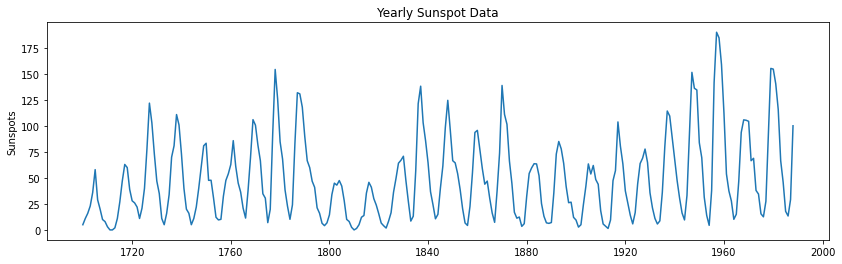

In [56]:
# read and plot data
data_path = 'https://vincentarelbundock.github.io/Rdatasets/csv/datasets/sunspot.year.csv'
data = pd.read_csv(data_path,usecols = ['time','value'],index_col = 'time',parse_dates=['time'])
plt.figure()
plt.plot(data.index,data['value'])
plt.ylabel('Sunspots')
plt.title('Yearly Sunspot Data');

In [57]:
data.head()

,value
time,
1700-01-01,5.0
1701-01-01,11.0
1702-01-01,16.0
1703-01-01,23.0
1704-01-01,36.0


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 289 entries, 1700-01-01 to 1988-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   289 non-null    float64
dtypes: float64(1)
memory usage: 4.5 KB


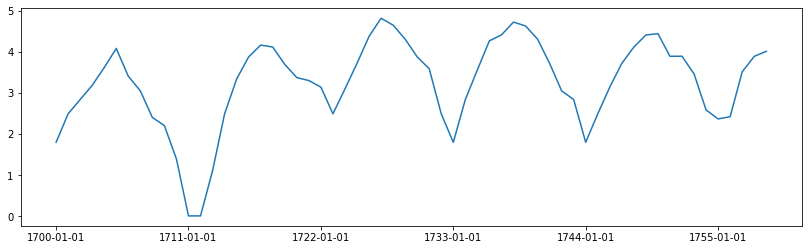

In [59]:
#given the difference in variance we should probably take log of data
data['log_ss'] = np.log1p(data['value'])
# going to zoom in on last 60 values to get a better idea of frequency of seasonality
plt.plot(data['log_ss'][:60])
plt.xticks(ticks = data.iloc[0:60:11].index)
plt.show()

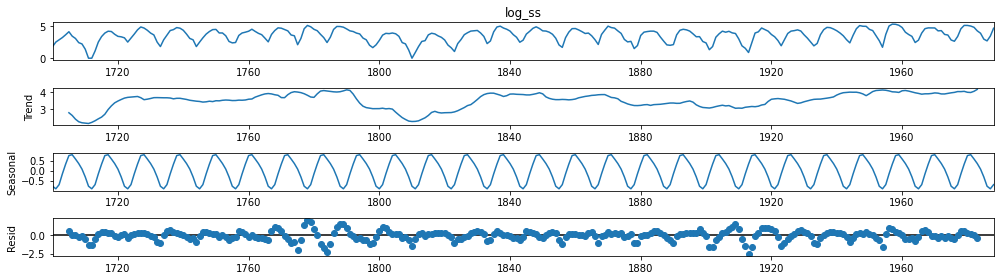

In [60]:
# plot decomposition with frequency 11
# Seems to do decent job of capturing seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(data.log_ss,freq=11).plot();

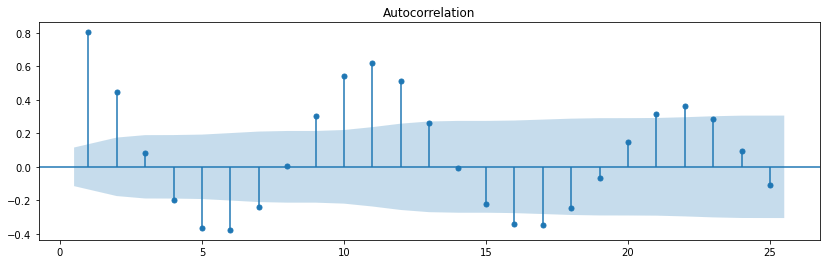

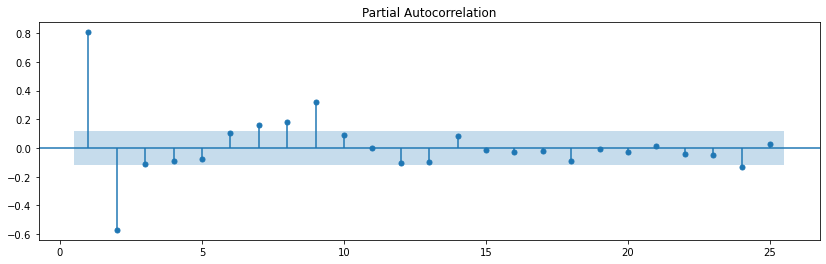

In [61]:
sm.tsa.graphics.plot_acf(data.log_ss,zero=False)
sm.tsa.graphics.plot_pacf(data.log_ss,zero = False);

In [62]:
data['lag_11'] = data.log_ss.shift(11)
data['seasonal_diff'] = data.log_ss - data['lag_11']

Test Statistic           -4.127070
p-value                   0.000873
Lags Used                12.000000
Observations Used       265.000000
Critical Value (1%)      -3.455270
Critical Value (5%)      -2.872509
Critical Value (10%)     -2.572615
dtype: float64


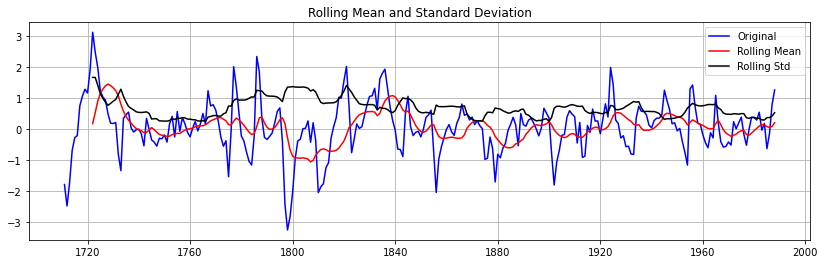

In [63]:
# mean moves, not perfect. p-value shows we can reject the null of non stationarity
dftest(data['seasonal_diff'].dropna())

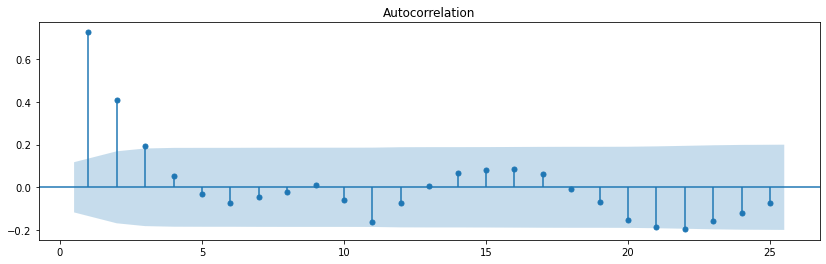

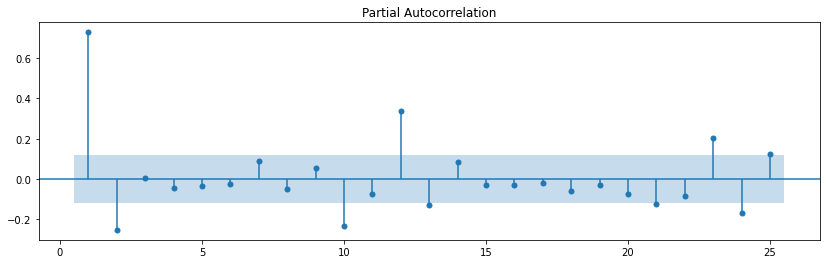

In [64]:
sm.tsa.graphics.plot_acf(data['seasonal_diff'].dropna(),zero=False)
sm.tsa.graphics.plot_pacf(data['seasonal_diff'].dropna(),zero=False);

looks like an ar2 model with seasonal differencing

In [65]:
sar3 = sm.tsa.statespace.SARIMAX(data.log_ss, 
                                order=(0,0,0), 
                                seasonal_order=(0,1,0,12), 
                                trend='c').fit()

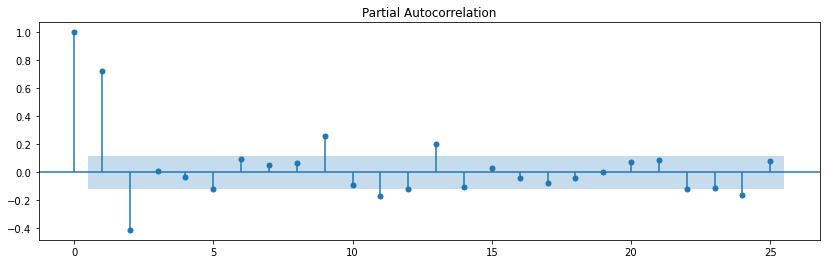

In [66]:
sm.tsa.graphics.plot_pacf(sar3.resid[sar3.loglikelihood_burn:]);

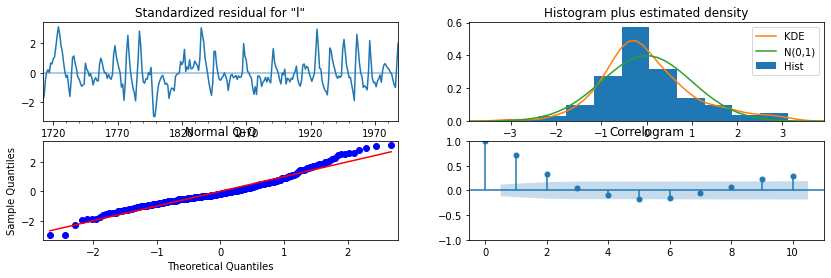

In [67]:
sar3.plot_diagnostics();

In [68]:
auto_model = pm.auto_arima(data.log_ss, start_p=0, start_q=0,
                           max_p=3, max_q=3, m=11,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[11] intercept   : AIC=694.412, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[11] intercept   : AIC=708.047, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[11] intercept   : AIC=464.732, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[11] intercept   : AIC=501.605, Time=0.34 sec
 ARIMA(0,0,0)(0,1,0)[11]             : AIC=707.239, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[11] intercept   : AIC=495.304, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[11] intercept   : AIC=450.988, Time=0.53 sec
 ARIMA(1,0,0)(2,1,1)[11] intercept   : AIC=inf, Time=2.37 sec
 ARIMA(1,0,0)(1,1,1)[11] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(0,0,0)(2,1,0)[11] intercept   : AIC=688.783, Time=0.38 sec
 ARIMA(2,0,0)(2,1,0)[11] intercept   : AIC=425.830, Time=0.71 sec
 ARIMA(2,0,0)(1,1,0)[11] intercept   : AIC=443.928, Time=0.28 sec
 ARIMA(2,0,0)(2,1,1)[11] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(2,0,0)(1,1,1)[11] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(3,0,0)(2,1,0)[11] intercept   : AIC=427.82

In [69]:
print(f"order: {auto_model.order}")
print(f"seasonal order: {auto_model.seasonal_order}")

order: (2, 0, 0)
seasonal order: (2, 1, 0, 11)


In [70]:
sar4 = sm.tsa.statespace.SARIMAX(data.log_ss, 
                                order=(2,0,0), 
                                seasonal_order=(0,1,0,12), 
                                trend='c').fit()

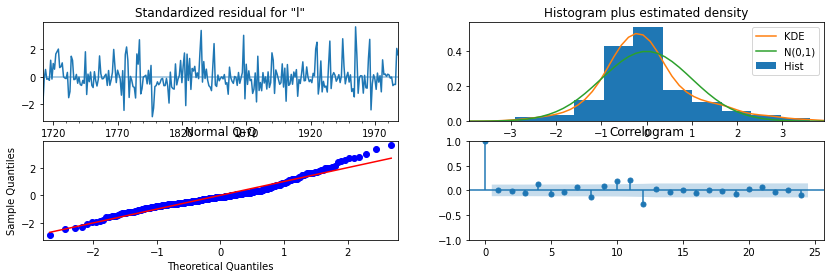

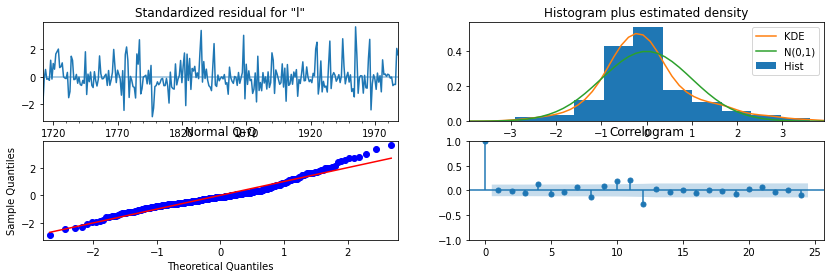

In [71]:
sar4.plot_diagnostics(lags=24)

In [72]:
warnings.filterwarnings("ignore")
series = data['log_ss']
horizon = 3
start = int(len(data.value)*.75)
step_size = 1
order = auto_model.order
seasonal_order = auto_model.seasonal_order

log_cv1 = cross_validate(series,horizon,start,step_size,
                    order = order,
                    seasonal_order = seasonal_order)

In [73]:
log_cv1 = np.expm1(log_cv1)

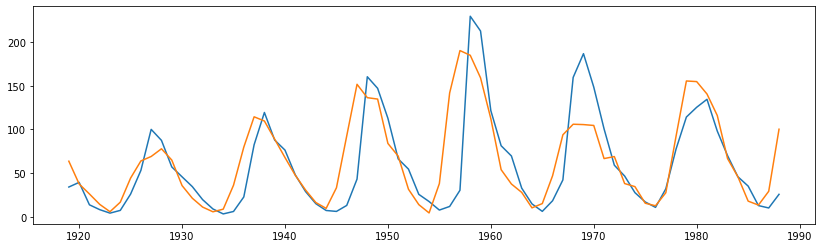

In [74]:
plt.plot(log_cv1)
plt.show()

In [75]:
mape(log_cv1)

0.37655034972992557

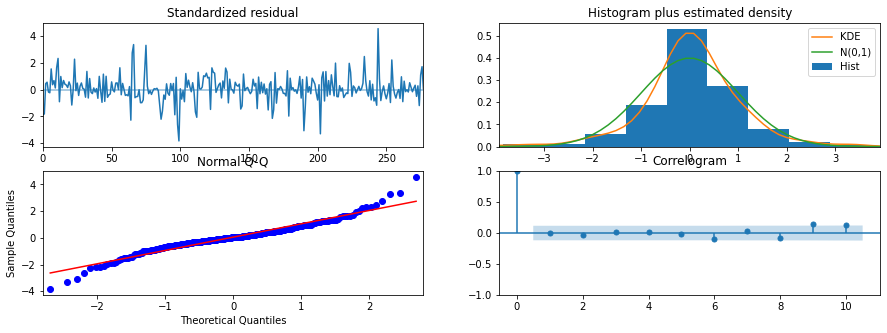

In [76]:
auto_model.plot_diagnostics(figsize = (15,5));

In [77]:
warnings.filterwarnings("ignore")
series = data['log_ss']
horizon = 3
start = int(len(data.value)*.75)
step_size = 1
order = (2,0,0)
seasonal_order = (1,1,0,11)

log_cv2 = cross_validate(series,horizon,start,step_size,
                    order = order,
                    seasonal_order = seasonal_order)

In [78]:
log_cv2 = np.expm1(log_cv2)

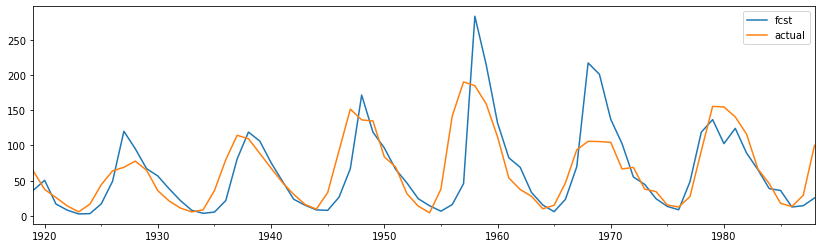

In [79]:
log_cv2.plot()
plt.show()

In [80]:
mape(log_cv2)

0.41376076521868793

# Section 6: Predicting with [Facebook Prophet](https://facebook.github.io/prophet/)

From site:

> Today Facebook is open sourcing Prophet, a forecasting tool available in Python and R. The idea is that producing high quality forecasts is not an easy problem for either machines or for most analysts. The models revolves around two main observations in the practice of creating a variety of business forecasts:
- Completely automatic forecasting techniques can be brittle and they are often too inflexible to incorporate useful assumptions or heuristics.
- Analysts who can produce high quality forecasts are quite rare because forecasting is a specialized data science skill requiring substantial experience.

Prophet is an general additive model that includes a number of highly advanced, intelligent [forecasting methods](http://andrewgelman.com/2017/03/01/facebooks-prophet-uses-stan/), including [changepoint analysis](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&ved=0ahUKEwjpwM_JhsbVAhWNxIMKHSWqD6kQFgguMAE&url=http%3A%2F%2Fwww.variation.com%2Fcpa%2Ftech%2Fchangepoint.html&usg=AFQjCNFK6wbwWuBCixZJHu03LkABXL3UHA):


> _y = g(t) + s(t) + h(t) + $\epsilon_t$_

- Here 
    - **g(t)** is the **trend function** which models non-periodic changes in the value of the time series, 
    - **s(t)** represents **periodic changes (e.g., weekly and yearly seasonality)**, 
    - **h(t)** represents the **effects of holidays which occur on potentially irregular schedules over one or more days**.

- **For trend, a piecewise linear or logistic growth curve trend is used.**
    - Prophet automatically detects changes in trends by selecting changepoints from the data.
- **For seasonalities, different seasonality components are modeled using Fourier series.**
- One can either use fb provided list or incorporate their own holidays into model.

Prophet was originally optimized with the business forecast tasks encountered at Facebook in mind, which typically have any of the following characteristics:

- Hourly, daily, or weekly observations with at least a few months (preferably a year) of history
- Strong multiple “human-scale” seasonalities: day of week and time of year
- Important holidays that occur at irregular intervals that are known in advance
- A reasonable number of missing observations or large outliers
- Historical trend changes, for instance due to product launches or logging changes
- Trends that are non-linear growth curves, where a trend hits a natural limit or saturates


[Technical details behind prophet](https://facebookincubator.github.io/prophet/static/prophet_paper_20170113.pdf): built around a generalized additive model (GAM)

In [81]:
# read daily page views for the Wikipedia page for Peyton Manning; scraped into hosted CSV
plt.rcParams['figure.figsize'] = [14, 4]

data_path = 'https://raw.githubusercontent.com/PinkWink/DataScience/master/data/07.%20example_wp_peyton_manning.csv'
peyton = pd.read_csv(data_path)

In [83]:
peyton.head()

,ds,y
0,2007-12-10,14629
1,2007-12-11,5012
2,2007-12-12,3582
3,2007-12-13,3205
4,2007-12-14,2680


In [84]:
peyton.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      2905 non-null   object
 1   y       2905 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.5+ KB


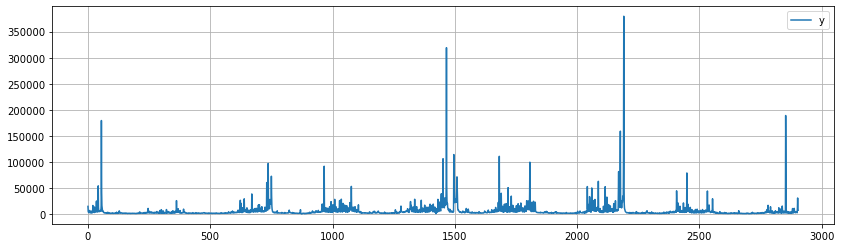

In [82]:
# plot data
peyton.plot()
plt.grid()
plt.show()

In [85]:
# log data due to spikes
# dataframe must have ds column with type datetime and y column which is time series we are trying to predict
peyton['y'] = np.log(peyton['y'])
peyton.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


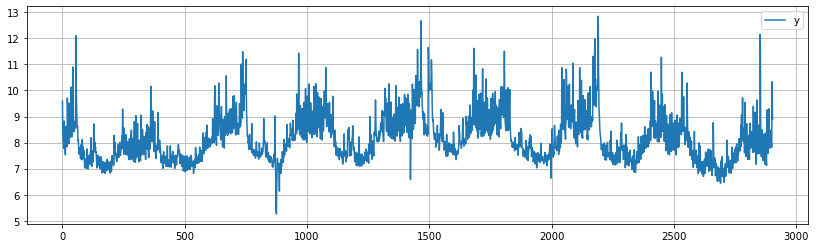

In [86]:
# plot log
peyton.plot()
plt.grid()
plt.show()

In [87]:
# fit model
m = Prophet()
m.fit(peyton)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [89]:
peyton.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [90]:
# forecast 365 days into future
# prophet requires a blank dataframe to input predictions
# will also provide blank set for dates within dataset to allow for fit
future = m.make_future_dataframe(periods=365)
print(future.head())
print(future.tail())

          ds
0 2007-12-10
1 2007-12-11
2 2007-12-12
3 2007-12-13
4 2007-12-14
             ds
3265 2017-01-15
3266 2017-01-16
3267 2017-01-17
3268 2017-01-18
3269 2017-01-19


In [91]:
future.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3270 entries, 0 to 3269
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3270 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 25.7 KB


In [95]:
# populate forecast
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.202479,7.520848,8.940170
3266,2017-01-16,8.527473,7.836623,9.296285
3267,2017-01-17,8.314861,7.632001,9.097607
3268,2017-01-18,8.147459,7.467241,8.851877
3269,2017-01-19,8.159363,7.449028,8.889630


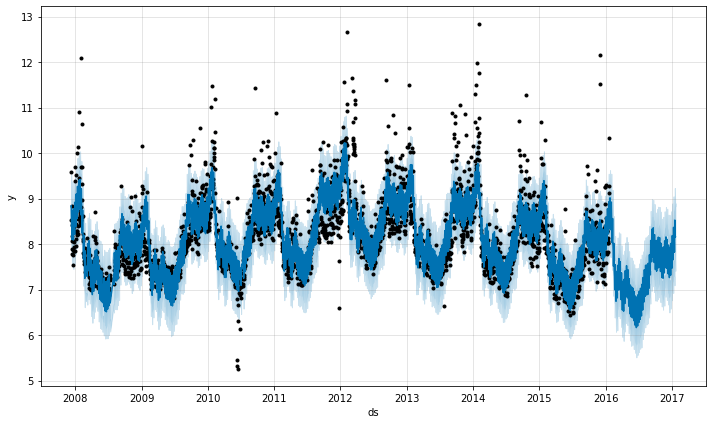

In [93]:
# plot forecast
m.plot(forecast)
plt.show()

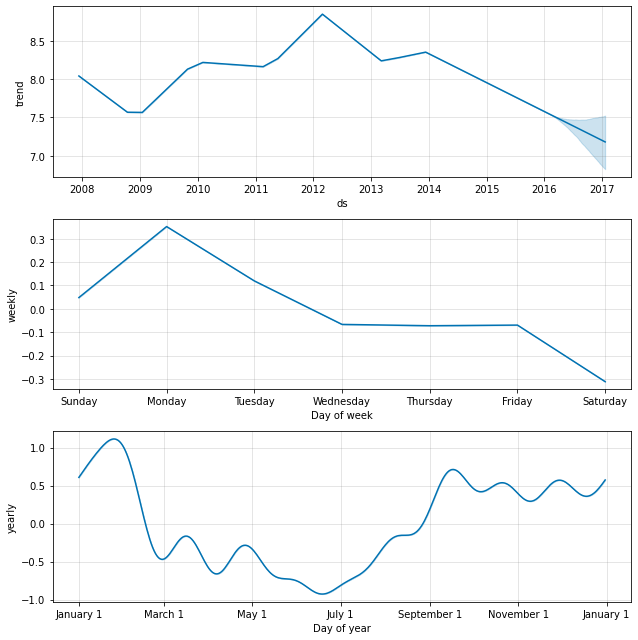

In [94]:
# plot individual components of forecast: trend, weekly/yearly seasonality
m.plot_components(forecast);

>We can also add holiday and Superbowl date information to Peyton's forecast, since we hypothesize people will visit his site more often on those dates.

In [96]:
# add holidays 
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0, # these help us specify spillover into previous and future days which will be treated as own holidays
  'upper_window': 1,
})

superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((playoffs, superbowls))

In [97]:
holidays.head()

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1


In [98]:
# fit and predict
m = Prophet(holidays=holidays)
forecast = m.fit(peyton).predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [99]:
# we can see the effects of various 'holidays' on site visits
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.222796,1.206278
2191,2014-02-03,1.906262,1.417991
2532,2015-01-11,1.222796,0.000000
2533,2015-01-12,1.906262,0.000000
2901,2016-01-17,1.222796,0.000000
2902,2016-01-18,1.906262,0.000000
2908,2016-01-24,1.222796,0.000000
2909,2016-01-25,1.906262,0.000000
2922,2016-02-07,1.222796,1.206278
2923,2016-02-08,1.906262,1.417991


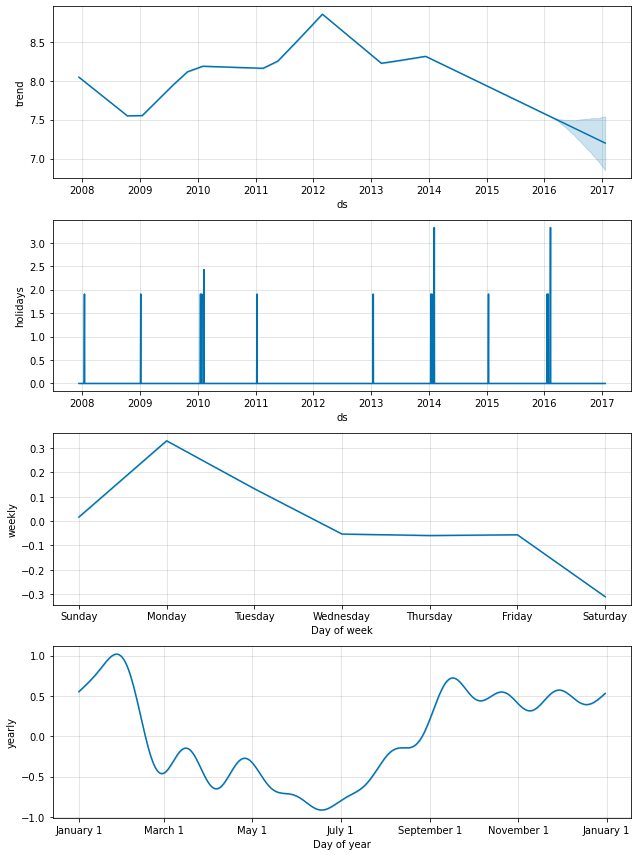

In [100]:
# check the impacts visually
m.plot_components(forecast);

>Peyton won Superbowls XLI (41, 2007) and 50 (2016), while losing XLIV (44, 2010) and XLVIII(48, 2014). We can see these spikes in the holidays chart.

In [101]:
# Add in another seasonality besides yearly, weekly, daily
# fit model
m = Prophet(holidays=holidays)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(peyton)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [102]:
fcst_month = m.predict(future)

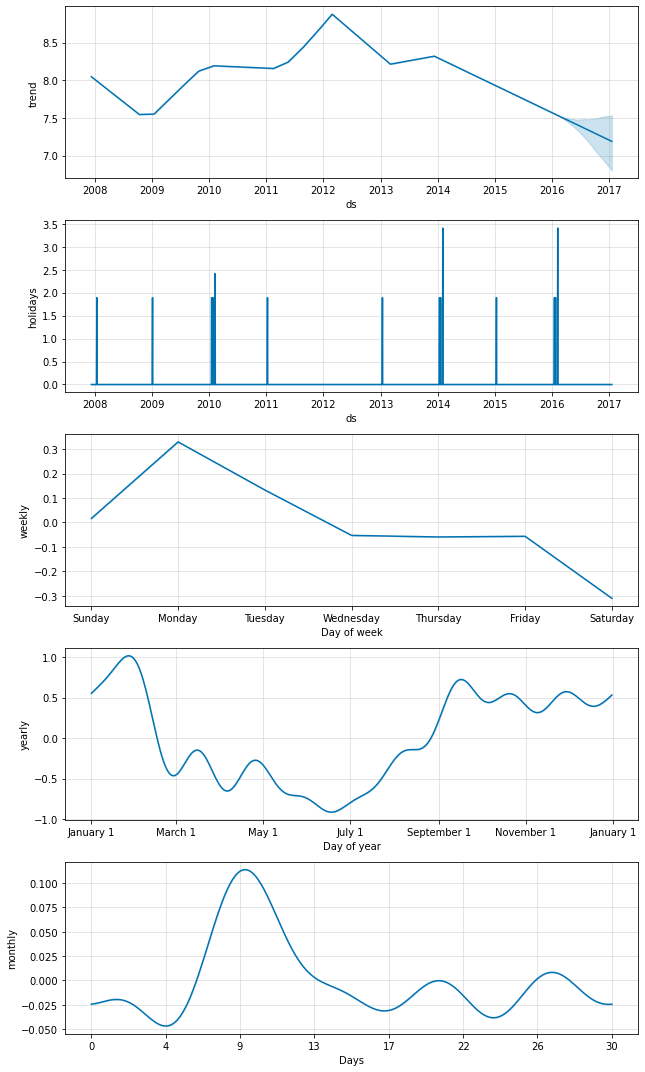

In [103]:
m.plot_components(fcst_month)
plt.show()

# Adding a regressor

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


              ds          y  nfl_sunday
0     2007-12-10   9.590761           0
1     2007-12-11   8.519590           0
2     2007-12-12   8.183677           0
3     2007-12-13   8.072467           0
4     2007-12-14   7.893572           0
...          ...        ...         ...
2900  2016-01-16   7.817223           0
2901  2016-01-17   9.273878           1
2902  2016-01-18  10.333775           0
2903  2016-01-19   9.125871           0
2904  2016-01-20   8.891374           0

[2905 rows x 3 columns]


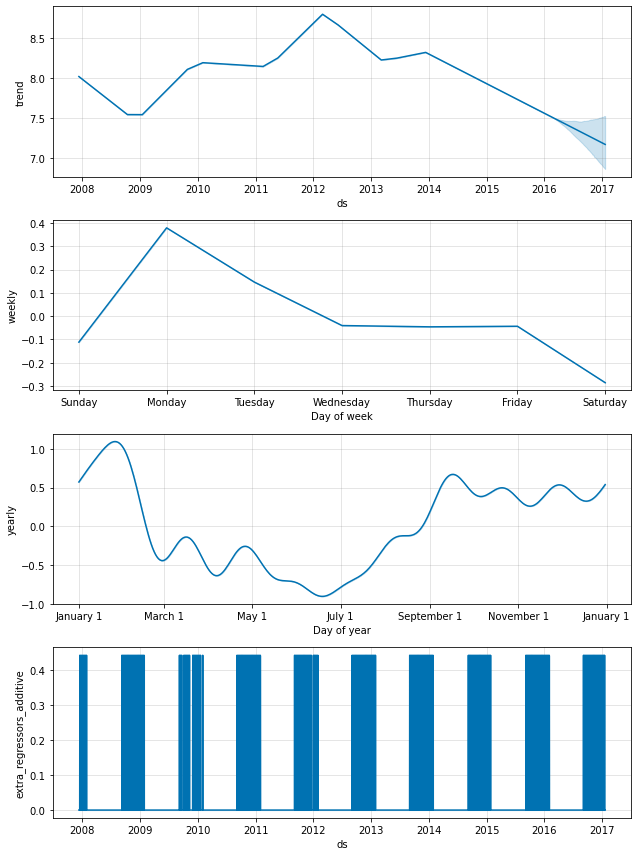

In [104]:
# creating indicator variable for nfl sundays
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
    
#adding that to our df
peyton['nfl_sunday'] = peyton['ds'].apply(nfl_sunday)
print(peyton)

m = Prophet()

# must be in the fit df
m.add_regressor('nfl_sunday')
m.fit(peyton)

# regressor must also be available in future df
future['nfl_sunday'] = future['ds'].apply(nfl_sunday)

forecast = m.predict(future)
fig = m.plot_components(forecast)

In [107]:
# These are points where trend has changed
print(f"Originally: {m.changepoints[:5]}")
# you can specify changepoints if you want trend to only be allowed at certain points
m_c = Prophet(changepoints=['2014-01-01'])

print(f"\nNow: {m_c.changepoints[:5]}")

Originally: 93    2008-03-17
186   2008-06-20
279   2008-10-11
372   2009-01-14
465   2009-04-17
Name: ds, dtype: datetime64[ns]

Now: 0   2014-01-01
Name: ds, dtype: datetime64[ns]


# Cross validation with fbprophet

In [108]:
from prophet.diagnostics import cross_validation
#Starting from 730 days in, making a prediction every 180 days, 365 days into the future
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
df_cv.head()

INFO:prophet:Making 11 forecasts with cutoffs between 2010-02-15 00:00:00 and 2015-01-20 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-16,8.999890,8.545894,9.500929,8.242493,2010-02-15
1,2010-02-17,8.765542,8.286580,9.238825,8.008033,2010-02-15
2,2010-02-18,8.650913,8.144221,9.153604,8.045268,2010-02-15
3,2010-02-19,8.571954,8.089374,9.082923,7.928766,2010-02-15
4,2010-02-20,8.314383,7.864918,8.838366,7.745003,2010-02-15


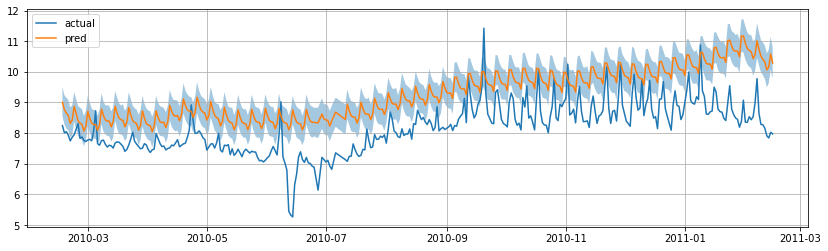

In [109]:
# Just looking at data from first cutoff
first_cut = df_cv[df_cv.cutoff == datetime(2010,2,15)]
plt.plot(first_cut.ds,first_cut.y,label='actual')
plt.plot(first_cut.ds,first_cut.yhat,label = 'pred')
plt.fill_between(first_cut.ds,first_cut.yhat_lower,first_cut.yhat_upper,alpha=0.4)
plt.grid()
plt.legend()
plt.show()

In [110]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.493996,0.702848,0.505325,0.058518,0.051446,0.058822,0.666514
1,38 days,0.499220,0.706555,0.509266,0.058961,0.050939,0.059335,0.667885
2,39 days,0.522153,0.722602,0.515925,0.059626,0.051446,0.060126,0.667656
3,40 days,0.529456,0.727637,0.518030,0.059851,0.050939,0.060420,0.666286
4,41 days,0.534142,0.730850,0.517269,0.059725,0.051268,0.060365,0.673824


***
## Predicting CO2

In [111]:
# load data
co2 = pd.read_csv('./co2-ppm-mauna-loa-19651980.csv', 
                  header = 0,
                  names = ['idx', 'co2'],
                  skipfooter = 2)
co2.head()

,idx,co2
0,1965-01,319.32
1,1965-02,320.36
2,1965-03,320.82
3,1965-04,322.06
4,1965-05,322.17


In [112]:
co2 = co2.drop('idx', 1)

# recast co2 col to float
co2['co2'] = pd.to_numeric(co2['co2'])
co2.drop(labels=0, inplace=True)

# set index
index = pd.date_range('1/1/1965', periods=191, freq='M')
co2.index = index

In [113]:
co2['ds'] = co2.index
co2.rename(columns={'co2': 'y'}, inplace=True)

co2.tail()

,y,ds
1980-07-31,337.19,1980-07-31
1980-08-31,335.49,1980-08-31
1980-09-30,336.63,1980-09-30
1980-10-31,337.74,1980-10-31
1980-11-30,338.36,1980-11-30


In [114]:
# fit model
model = Prophet()
model.fit(co2)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [115]:
future = model.make_future_dataframe(periods=120, freq='M', include_history=True)
future.tail()

,ds
306,1990-07-31
307,1990-08-31
308,1990-09-30
309,1990-10-31
310,1990-11-30


In [116]:
# populate forecast
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
306,1990-07-31,354.920920,336.680218,371.759970,337.801850,372.832500,-1.117569,-1.117569,-1.117569,-1.117569,-1.117569,-1.117569,0.0,0.0,0.0,353.803350
307,1990-08-31,355.059181,334.758280,370.318917,337.683390,373.317588,-2.909000,-2.909000,-2.909000,-2.909000,-2.909000,-2.909000,0.0,0.0,0.0,352.150181
308,1990-09-30,355.192982,334.314400,370.547740,337.580203,373.708832,-3.146850,-3.146850,-3.146850,-3.146850,-3.146850,-3.146850,0.0,0.0,0.0,352.046132
309,1990-10-31,355.331244,335.500290,372.122597,337.390904,374.121748,-2.000568,-2.000568,-2.000568,-2.000568,-2.000568,-2.000568,0.0,0.0,0.0,353.330675
310,1990-11-30,355.465045,336.433039,373.634340,337.321359,374.439719,-0.940574,-0.940574,-0.940574,-0.940574,-0.940574,-0.940574,0.0,0.0,0.0,354.524471


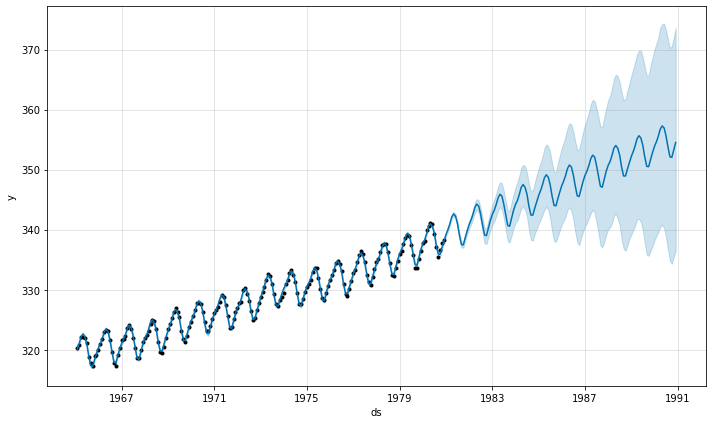

In [117]:
model.plot(forecast);

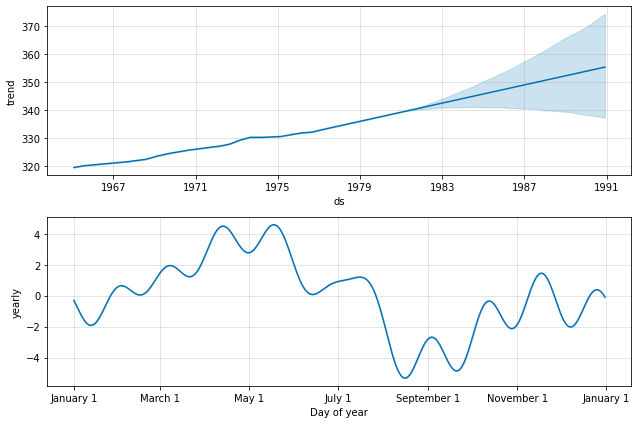

In [118]:
# plot individual components of forecast: trend, weekly/yearly seasonality,
model.plot_components(forecast);

## Things to look into adjusting

In [119]:
# Decreased drastically from defaults
changepoint_prior_scale = 0.05
seasonality_prior_scale = 0.00001

growth='logistic'

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


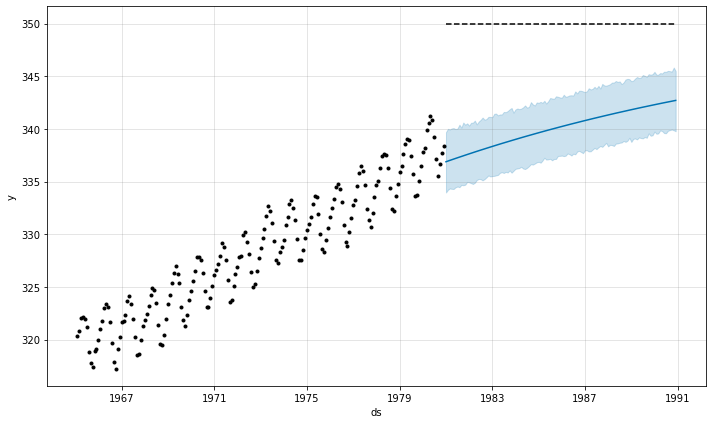

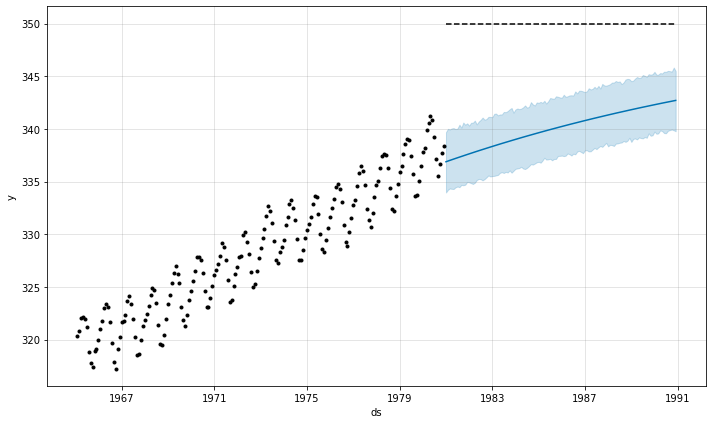

In [120]:
# we can add a cap to limit our theoretical growth if we are using logistic growth
co2['cap'] = 350
m = Prophet(growth=growth, #weekly_seasonality=10000,
            
            seasonality_prior_scale=seasonality_prior_scale,
            changepoint_prior_scale=changepoint_prior_scale)
m.fit(co2);

# forecast 15 years into future with cap of 380
future = m.make_future_dataframe(periods=120,freq='M', include_history=False)
future['cap'] = 350

forecast = m.predict(future)
m.plot(forecast)

# Exercise
* In this exercise we are going to use [FiveCitiesPM](https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities) dataset.
* Create prediction using hourly data of PM_Dongsi for last day half of december of 2015
    * Note you will have to use what we first learned to convert the year, month, day, hour columns to datetime object
* Plot daily and weekly seasonality of forecast

In [121]:
df_Beijing = pd.read_csv('./FiveCitiesPM/Beijing.csv')
df_Beijing.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


In [122]:
# Create a new column that is a datetime object
def make_date(row):
    return datetime(year = row['year'], month = row['month'], day = row['day'], hour = row['hour'])

df_Beijing['date'] = df_Beijing.apply(make_date,axis=1)
# Make index for easy indexing of time values

df_Beijing.set_index('date',inplace=True)
df_Beijing['ds'] = df_Beijing.index

# Only take required fields
df = df_Beijing[["ds",'PM_Dongsi']]
df.rename(columns = {'PM_Dongsi':'y'},inplace=True)

df_train = df['2015-11']
df_test = df['2015-12':'2015-12-15']
print(df_train.tail())
print(df_test.tail())

                                     ds      y
date                                          
2015-11-30 19:00:00 2015-11-30 19:00:00  685.0
2015-11-30 20:00:00 2015-11-30 20:00:00  685.0
2015-11-30 21:00:00 2015-11-30 21:00:00  638.0
2015-11-30 22:00:00 2015-11-30 22:00:00  548.0
2015-11-30 23:00:00 2015-11-30 23:00:00  490.0
                                     ds    y
date                                        
2015-12-15 19:00:00 2015-12-15 19:00:00  9.0
2015-12-15 20:00:00 2015-12-15 20:00:00  7.0
2015-12-15 21:00:00 2015-12-15 21:00:00  6.0
2015-12-15 22:00:00 2015-12-15 22:00:00  4.0
2015-12-15 23:00:00 2015-12-15 23:00:00  6.0


In [123]:
# fit model
m = Prophet()
m.fit(df_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [124]:
future = m.make_future_dataframe(periods = 15*24,freq = 'h') # could also leave default freq of days and do 31 for period
print(future.head())
future.tail()

                   ds
0 2015-11-01 00:00:00
1 2015-11-01 01:00:00
2 2015-11-01 02:00:00
3 2015-11-01 03:00:00
4 2015-11-01 04:00:00


,ds
1075,2015-12-15 19:00:00
1076,2015-12-15 20:00:00
1077,2015-12-15 21:00:00
1078,2015-12-15 22:00:00
1079,2015-12-15 23:00:00


In [125]:
# populate forecast
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat,yhat_lower,yhat_upper
1075,2015-12-15 19:00:00,1392.969505,1120.948454,1685.297855
1076,2015-12-15 20:00:00,1395.399688,1115.939545,1683.310902
1077,2015-12-15 21:00:00,1394.305889,1100.684108,1670.738701
1078,2015-12-15 22:00:00,1391.495655,1107.185690,1677.395947
1079,2015-12-15 23:00:00,1388.187388,1106.537531,1669.170485


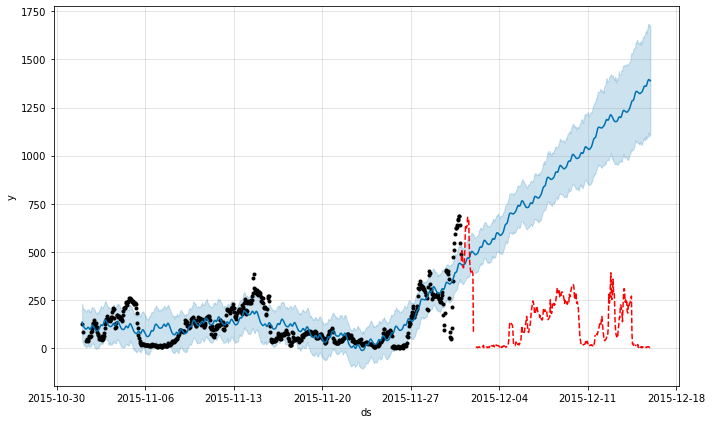

In [126]:
m.plot(forecast)
plt.plot(df_test.y,'r--')
plt.show()

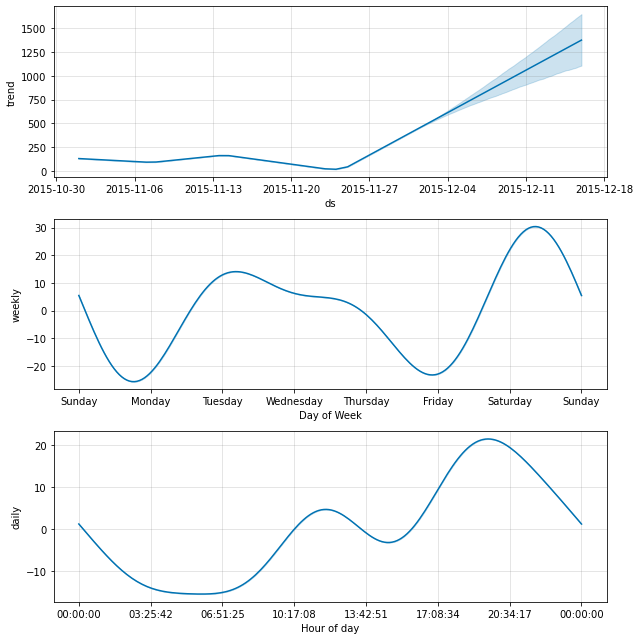

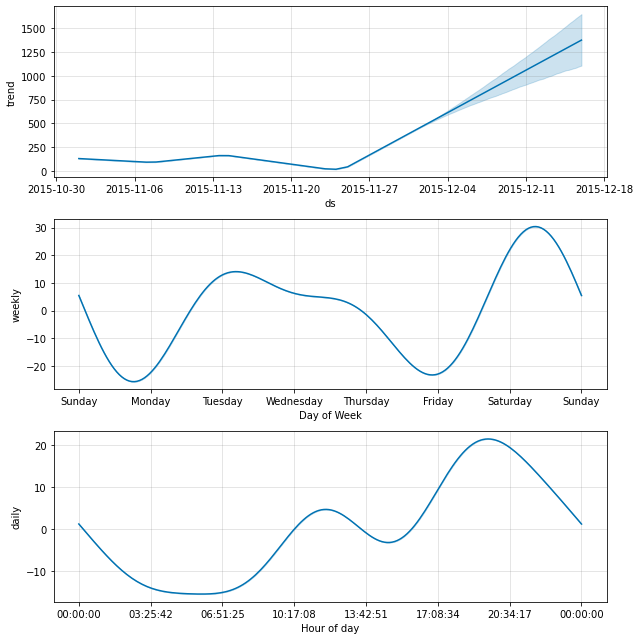

In [127]:
m.plot_components(forecast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


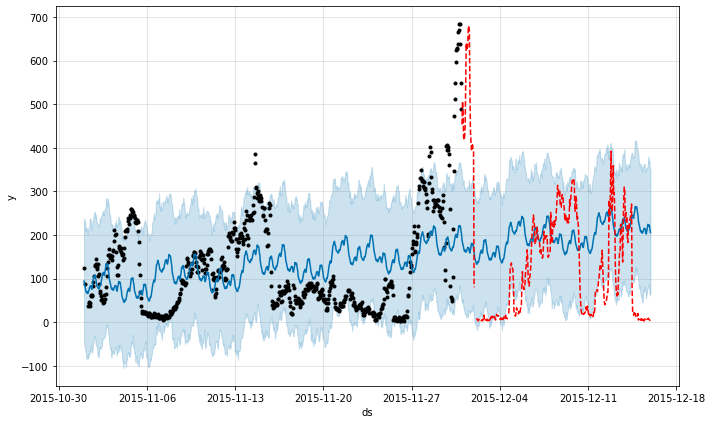

In [128]:
# Decreased drastically from defaults
changepoint_prior_scale = 0.0005
seasonality_prior_scale = 10


m = Prophet(daily_seasonality=10,
            
            seasonality_prior_scale=seasonality_prior_scale,
            changepoint_prior_scale=changepoint_prior_scale)
m.fit(df_train);


forecast = m.predict(future)
m.plot(forecast)
plt.plot(df_test.y,'r--')

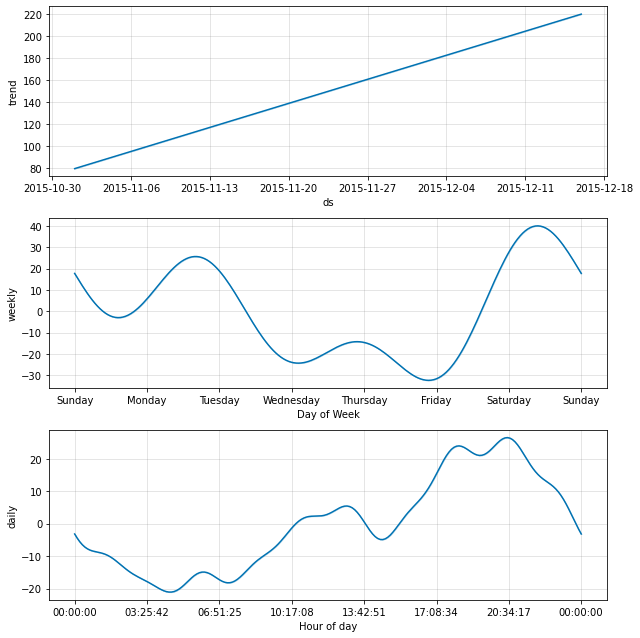

In [129]:
m.plot_components(forecast);

# Summary
In this notebook, we have covered: 
1. A practical understanding of **Autoregressive Moving Average (ARMA)** models.
2. A basic understanding of the **Autocorrelation Function (ACF)**.
3. Insight into choosing the order *q* of **Moving Average (MA)** models.
4. A practical understanding of **Autoregressive (AR)** models.
5. A basic understanding of the **Partial Autocorrelation Function (PACF)**.
6. Insight into choosing the order *p* of **AR** models.

***